
# <center> Flow Matching and Rectified Flow

<div align=center>

[KAIST CS492(C): Diffusion and Flow Models (Fall 2025)](https://mhsung.github.io/kaist-cs492c-fall-2025/)

Programming Assignment 3: Flow Matching

Instructor: [Minhyuk Sung](https://mhsung.github.io) (mhsung [at] kaist.ac.kr)

TA: [Seungwoo Yoo](https://dvelopery0115.github.io/) (dreamy1534 [at] kaist.ac.kr)

Credit: [Juil Koo](https://63days.github.io/) (63days [at] kaist.ac.kr)

<img src="assets/trajectory_visualization.png"></img>
</div>

## Abstract
Flow Matching (FM) is a novel generative framework that shares similarities with diffusion models, particularly in how both tackle the Optimal Transport problem through an iterative process. Similar to diffusion models, FM also splits the sampling process into several time-dependent steps. At first glance, FM and diffusion models may seem almost identical due to their shared iterative sampling approach. However, the key differences lie in the objectve function and the choice of trajectories in FM.

Regarding the objective function, diffusion models predict the injected noise during training. In contrast, Flow Matching predicts the displacement between the data distribution and the prior distribution.

Moreover, Flow Matching is developed from the perspective of _flow_, a time-dependent transformation function that corresponds to the forward pass in diffusion models. Unlike diffuison models, where the forward pass is fixed to ensure that every intermediate distribution also follows a Gaussian distribution, FM offers much greater flexibility in the choice of _flow_. This flexibility allows for the use of simpler trajectories, such as linear interpolation over time, between the data distribution and the prior distribution. Experimental results have sohwn that the FM objective and its simpler trajectory are highly effective in modeling the data distribution, Making FM a compelling alternative to diffusion models.

Furthermore, the concept of flows and their inducing vector fields gives rise to a technique known as rectification—a training-based approach for accelerating sampling in flow models. The key idea of rectification is to straighten the trajectories that transport the prior distribution to the target distribution, thereby reducing the number of inference steps required to generate new samples.

In this assignment, we will take a deep dive into the core components of the Flow Matching and Rectified Flow frameworks by implementing them step-by-step.

<center>

**Detailed submission guidelines and grading criteria are provided at the end of this Jupyter notebook.**

</center>

## Quick Summary of Flow Matching

<center>

**You can skip this summary and go directly to the implementation part below if you are already familiar with these models.**

</center>

In this assignment, we will first explore Flow Matching (FM), a method that, like diffusion models, deals with time-dependent trajectories but does so from the perspective of vector fields that construct probability density paths. At a high level, FM shares similarities with diffusion models but offers more straight trajectories. Unlike the diffusion models, whose trajectories involve nonlinear terms that add unnecessary complexity, the trajectories in FM can be much simpler. They can be represented as a simple linear interpolation between the data point $x_0$ and random noise $x_1$​ over time $t$. As before, we recommend thoroughly understanding the equations presented in the papers before starting the assignment. The following is a list of recommended resources:

1. [[Paper](https://arxiv.org/abs/2210.02747)] Flow Matching for Generative Modeling (FM)
2. [[Paper](https://arxiv.org/abs/2209.03003)] Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow (RF)
3. [[Blog](https://mlg.eng.cam.ac.uk/blog/2024/01/20/flow-matching.html)] An Introduction to Flow Matching

Further material is listed at the bottom of the notebook.

### Modeling the Data Distribution with Flow
In FM, we have a probability density path $p: [0,1] \times \mathbb{R}^d \rightarrow \mathbb{R}_{>0}$, which is a time dependent probabilty density function, i.e., $\int p_t(x) dx = 1$. Starting from the simple tractable distribution $p_0(x) = p_{\text{prior}}$, we aim to transform it into a more complex distribution $p_1(x) = p_{\text{data}}$ using a time-dependent diffeomorphic map, called _flow_: $\psi: [0,1] \times \mathbb{R}^d \rightarrow \mathbb{R}^d$. Rather than directly modeling the flow itself, as we've done in diffusion models, we instead model the derivative of the flow with respect to $t$, which is called _vector field_ $\frac{d}{dt}\psi_t(x) = v_t(\psi_t(x))$.
Given a target probability density path $p_t(x)$ and a corresponding vector field $u_t(x)$, we define the Flow Matching objective as:

$$
\begin{align*}
{L}_{\text{FM}} (\theta) = \mathbb{E}_{t, p_t(x)} \Vert v_t(x;\theta) - u_t(x) \Vert^2
\end{align*}.
$$

However, since $p_t$ and $u_t$ are intractable, we make the training simpler by modeling the conditional probability paths and vector fields:

$$
\begin{align*}
p_t(x) &= \int p_t(x | x_1) q(x_1) dx_1 \\
u_t(x) &= \int u_t(x | x_1) \frac{p_t(x | x_1) q(x_1)} {p_t(x)} dx_1
\end{align*}
$$

The equations above can be derived from the _continuity equation_: $\partial p_t(x) / \partial t = -\nabla \cdot (p_t(x) v_t(x)).$
See the appendix A of the FM paper for more details.

Given the conditional probabiliy paths $p_t(x|x_1)$ and vector fields $u_t(x | x_1)$, we define conditional flow matching objective as:

$$
\begin{align*}
{L}_{\text{CFM}} (\theta) = \mathbb{E}_{t, p_1(x_1), p_t(x | x_1)} \Vert v_t(x;\theta) - u_t(x | x_1) \Vert^2
\end{align*}
$$

### Special instances of Flow Matching
While the conditional probability paths and vector fields can be designed in various ways, we opt for the simplest vector field, which takes the form of a Gaussian kernel:

$$
\begin{align*}
p_t(x | x_1) &= {N}(x | \mu_t(x_1), \sigma_t(x_1)^2 I) \\
\psi_t(x) &= \sigma_t(x_1)x + \mu_t(x_1)
\end{align*}.
$$

Specifically, we set $\mu_t(x) = tx_1$, and $\sigma_t(x) = 1 - (1 - \sigma_{\text{min}})t$. Given the $\mu_t(x)$ and $\sigma_t(x)$, the conditional flow is defined as follows: $\psi_t(x) = (1 - (1 - \sigma_{\text{min}} )t)x + tx_1$.

In this case, the CFM loss takes the following form:

$$
\begin{align*}
{L}_{\text{CFM}} (\theta) = \mathbb{E}_{t, p_1(x_1), p_t(x | x_1)} \Vert v_t(\psi_t(x_0);\theta) - (x_1 - (1 - \sigma_{\text{min}}) x_0) \Vert^2
\end{align*}
$$

## Setup

Before getting started, go to `Runtime` → `Change runtime type` on the top menu bar, and choose **T4 GPU** under Hardware Accelerator.

You should then see `True` and the GPU status with the commands below:

In [1]:
import torch
print(torch.cuda.is_available())
!nvidia-smi

True
Sat Nov 22 06:29:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+

## Import Dependencies

In [2]:
import io
import math
from ipywidgets import interact, IntSlider, Output
from IPython.display import display, clear_output
from PIL import Image
from typing import List, Optional, Union

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist
from sklearn import datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import random

## Dataset and Utils

In [3]:
SEED = 63 # for reproducibility (Oct 14th)
def seed_everything(seed: int, cuda: bool = True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda and torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # For deterministic behavior (some operations may still be nondeterministic)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def normalize(ds, scaling_factor=2.0):
    return (ds - ds.mean()) / ds.std() * scaling_factor


def chamfer_distance(S1, S2) -> float:
    r"""
    Computes the Chamfer distance between two point clouds defined as:
    d_CD(S1, S2) = \sigma_{x \in S1} min_{y in S2} ||x - y||^2 + \sigma_{y \in S2} min_{x in S1} ||x - y||^2
    """
    dist = cdist(S1, S2)
    dist1 = dist.min(axis=1) ** 2
    dist2 = dist.min(axis=0) ** 2
    return dist1.sum() + dist2.sum()


def sample_checkerboard(n):
    # https://github.com/ghliu/SB-FBSDE/blob/main/data.py
    n_points = 3 * n
    n_classes = 2
    freq = 5
    x = np.random.uniform(
        -(freq // 2) * np.pi, (freq // 2) * np.pi, size=(n_points, n_classes)
    )
    mask = np.logical_or(
        np.logical_and(np.sin(x[:, 0]) > 0.0, np.sin(x[:, 1]) > 0.0),
        np.logical_and(np.sin(x[:, 0]) < 0.0, np.sin(x[:, 1]) < 0.0),
    )
    y = np.eye(n_classes)[1 * mask]
    x0 = x[:, 0] * y[:, 0]
    x1 = x[:, 1] * y[:, 0]
    sample = np.concatenate([x0[..., None], x1[..., None]], axis=-1)
    sqr = np.sum(np.square(sample), axis=-1)
    idxs = np.where(sqr == 0)
    sample = np.delete(sample, idxs, axis=0)

    return sample


def load_twodim(num_samples: int, dataset: str, dimension: int = 2):

    if dataset == "gaussian_centered":
        sample = np.random.normal(size=(num_samples, dimension))
        sample = sample

    if dataset == "gaussian_shift":
        sample = np.random.normal(size=(num_samples, dimension))
        sample = sample + 1.5

    if dataset == "circle":
        X, y = datasets.make_circles(
            n_samples=num_samples, noise=0.0, random_state=None, factor=0.5
        )
        sample = X * 4

    if dataset == "scurve":
        X, y = datasets.make_s_curve(
            n_samples=num_samples, noise=0.0, random_state=None
        )
        sample = normalize(X[:, [0, 2]])

    if dataset == "moon":
        X, y = datasets.make_moons(n_samples=num_samples, noise=0.0, random_state=None)
        sample = normalize(X)

    if dataset == "swiss_roll":
        X, y = datasets.make_swiss_roll(
            n_samples=num_samples, noise=0.0, random_state=None, hole=True
        )
        sample = normalize(X[:, [0, 2]])

    if dataset == "checkerboard":
        sample = normalize(sample_checkerboard(num_samples))

    return torch.tensor(sample).float()


class TwoDimDataClass(Dataset):
    def __init__(self, dataset_type: str, N: int, batch_size: int, dimension=2):

        self.X = load_twodim(N, dataset_type, dimension=dimension)
        self.name = dataset_type
        self.batch_size = batch_size
        self.dimension = 2

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]

    def get_dataloader(self, shuffle=True):
        return DataLoader(
            self,
            batch_size=self.batch_size,
            shuffle=shuffle,
            pin_memory=True,
        )


def get_data_iterator(iterable):
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()


## Visualize target and prior distributions

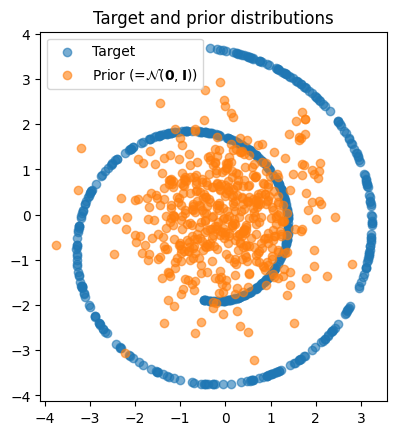

In [4]:
seed_everything(SEED) # for reproducibility (Oct 14th)

target_ds = TwoDimDataClass(dataset_type='swiss_roll',
                            N=1000000,
                            batch_size=256)

prior_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                           N=1000000,
                           batch_size=256)

num_vis_particles = 500
sample_f = target_ds[0:num_vis_particles]
sample_b = prior_ds[0:num_vis_particles]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample_f[:, 0], sample_f[:, 1], alpha=0.6)
ax.scatter(sample_b[:, 0], sample_b[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and prior distributions"
ax.set_title(strtitle)
ax.legend(['Target', r'Prior (=$\mathcal{N}(\mathbf{0}, \mathbf{I})$)'])

## Copy the Previous Implementation

We will use the same neural network architecture as in Assignments 1 and 2. Please copy your previous implementation.

In [5]:
class TimeEmbedding(nn.Module):
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period)
            * torch.arange(start=0, end=half, dtype=torch.float32)
            / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
        return embedding

    def forward(self, t: torch.Tensor):
        if t.ndim == 0:
            t = t.unsqueeze(-1)
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb


class TimeLinear(nn.Module):
    def __init__(self, dim_in: int, dim_out: int, num_timesteps: int):
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.num_timesteps = num_timesteps

        self.time_embedding = TimeEmbedding(dim_out)
        self.fc = nn.Linear(dim_in, dim_out)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.fc(x)
        alpha = self.time_embedding(t).view(-1, self.dim_out)

        return alpha * x


class SimpleNet(nn.Module):
    def __init__(
        self, dim_in: int, dim_out: int, dim_hids: List[int], num_timesteps: int
    ):
        super().__init__()
        """
        (TODO) Build a noise estimating network.

        Args:
            dim_in: dimension of input
            dim_out: dimension of output
            dim_hids: dimensions of hidden features
            num_timesteps: number of timesteps
        """

        ######## TODO ########
        # DO NOT change the code outside this part.

        widths = [dim_in] + dim_hids + [dim_out] # widths= [dim_in, dim_hids, dim_out] list of the layers in order
        layers=[]
        for k in range(len(widths)-1):
          layers.append(TimeLinear(widths[k], widths[k+1], num_timesteps))

        self.tlins=nn.ModuleList(layers) # stack of time_modulated linear layers




        ######################

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        (TODO) Implement the forward pass. This should output
        the noise prediction of the noisy input x at timestep t.

        Args:
            x: the noisy data after t period diffusion
            t: the time that the forward diffusion has been running
        """
        ######## TODO ########
        # DO NOT change the code outside this part.
        for i in range(len(self.tlins)):
            x=self.tlins[i](x,t) # ith linear layer: f(x,t)
            if i< len(self.tlins)-1:
              x=F.relu(x,inplace=True) # relu activation except last layer

        ######################
        return x








# class TimeEmbedding(nn.Module):
#     def __init__(self, hidden_size, frequency_embedding_size=256):
#         super().__init__()
#         self.mlp = nn.Sequential(
#             nn.Linear(frequency_embedding_size, hidden_size, bias=True),
#             nn.SiLU(),
#             nn.Linear(hidden_size, hidden_size, bias=True),
#         )
#         self.frequency_embedding_size = frequency_embedding_size

#     #@staticmethod
#     def timestep_embedding(t, dim, max_period=10000):
#         """
#         Create sinusoidal timestep embeddings.
#         :param t: a 1-D Tensor of N indices, one per batch element.
#                           These may be fractional.
#         :param dim: the dimension of the output.
#         :param max_period: controls the minimum frequency of the embeddings.
#         :return: an (N, D) Tensor of positional embeddings.
#         """
#         # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
#         half = dim // 2
#         freqs = torch.exp(
#             -math.log(max_period)
#             * torch.arange(start=0, end=half, dtype=torch.float32)
#             / half
#         ).to(device=t.device)
#         args = t[:, None].float() * freqs[None]
#         embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
#         if dim % 2:
#             embedding = torch.cat(
#                 [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
#             )
#         return embedding

#     def forward(self, t: torch.Tensor):
#         if t.ndim == 0:
#             t = t.unsqueeze(-1)
#         t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
#         t_emb = self.mlp(t_freq)
#         return t_emb


# class TimeLinear(nn.Module):
#     def __init__(self, dim_in: int, dim_out: int, num_timesteps: int):
#         super().__init__()
#         self.dim_in = dim_in
#         self.dim_out = dim_out
#         self.num_timesteps = num_timesteps

#         self.time_embedding = TimeEmbedding(dim_out)
#         self.fc = nn.Linear(dim_in, dim_out)

#     def forward(self, x: torch.Tensor, t: torch.Tensor):
#         x = self.fc(x)
#         alpha = self.time_embedding(t).view(-1, self.dim_out)

#         return alpha * x


# class SimpleNet(nn.Module):
#     def __init__(
#         self, dim_in: int, dim_out: int, dim_hids: List[int], num_timesteps: int
#     ):
#         super().__init__()
#         """
#         (TODO) Build a noise estimating network.

#         Args:
#             dim_in: dimension of input
#             dim_out: dimension of output
#             dim_hids: dimensions of hidden features
#             num_timesteps: number of timesteps
#         """

#         ######## TODO ########
#         # DO NOT change the code outside this part.
#         raise NotImplementedError('todo')
#         ######################

#     def forward(self, x: torch.Tensor, t: torch.Tensor):
#         """
#         (TODO) Implement the forward pass. This should output
#         the noise prediction of the noisy input x at timestep t.

#         Args:
#             x: the noisy data after t period diffusion
#             t: the time that the forward diffusion has been running
#         """
#         ######## TODO ########
#         # DO NOT change the code outside this part.
#         raise NotImplementedError('todo')
#         ######################
#         return x


## Implement Flow Matching Scheduler

Complete the functions `compute_psi_t()` and `step()` of `FMScheduler` class in the cell below.

The function `compute_psi_t` perturbs a clean data sample $x_1$ by linearly interpolating between $x_1$ and a sample $x_0$ drawn from the prior distribution $p_0$:
$$
   x_t = (1 - t) x_0 + t x_1
$$

The function `step` performs a single step of the ODESolver, solving the ODE from $t=0$ to $t=1$. While more sophisticated numerical methods (*e.g.*, Runge-Kutta) could be employed, in this assignment we will focus on the simplest approach—the first-order Euler method—for simplicity.

$$
\begin{align*}
x_{t+\Delta t} = x_t + \Delta t \frac{\partial x_t}{\partial t},
\end{align*}
$$

where $\frac{\partial x_t}{\partial t}$ is the vector field modeled by a neural network.




In [11]:
def expand_t(t, x):
    for _ in range(x.ndim - 1):
        t = t.unsqueeze(-1)
    return t

class FMScheduler(nn.Module):
    def __init__(self, num_train_timesteps=1000, sigma_min=0.001):
        super().__init__()
        self.num_train_timesteps = num_train_timesteps
        self.sigma_min = sigma_min

    def uniform_sample_t(self, batch_size) -> torch.LongTensor:
        ts = (
            np.random.choice(np.arange(self.num_train_timesteps), batch_size)
            / self.num_train_timesteps
        )
        return torch.from_numpy(ts)

    def compute_psi_t(self, x1, t, x0):
        """
        Compute the conditional flow psi_t(x | x_1).

        Note that the time convention is opposite to DDPM/DDIM.
        As t moves from 0 to 1, the probability paths shift from a prior distribution p_0(x)
        to a more complex data distribution p_1(x).

        Input:
            x1 (`torch.Tensor`): Data sample from the data distribution.
            t (`torch.Tensor`): Timestep in [0,1).
            x0 (`torch.Tensor`): The input to the conditional psi_t(x).
        Output:
            psi_t (`torch.Tensor`): Corrupted data sample obtained by linearly interpolating x1 and x0.
        """
        t = expand_t(t, x1)

        ######## TODO ########
        # DO NOT change the code outside this part.
        # compute psi_t(x)
        # raise NotImplementedError('todo')
        psi_t= (1-t)*x0 + t*x1
        ######################

        return psi_t

    def step(self, xt, vt, dt):
        """
        The simplest ode solver as the first-order Euler method:
        x_next = xt + dt * vt
        """

        ######## TODO ########
        # DO NOT change the code outside this part.
        # implement each step of the first-order Euler method.
        # raise NotImplementedError('todo')
        dt = expand_t(dt, xt) # Ensure dt is broadcastable with xt and vt
        x_next= xt + vt*dt
        ######################

        return x_next

## Implement the Conditional Flow Matching Objective and Sampling

- Complete the function `compute_loss` of `FlowMatching` that corresponds to the conditional flow matching objective written in Eq. 23 of the FM paper.
- Complete the function `sample` of `FlowMatching` used for generation.

In [12]:
class FlowMatching(nn.Module):
    def __init__(self, network: nn.Module, fm_scheduler: FMScheduler, **kwargs):
        super().__init__()
        self.network = network
        self.fm_scheduler = fm_scheduler

    @property
    def device(self):
        return next(self.network.parameters()).device

    def compute_loss(self, x1, x0=None):
        """
        The conditional flow matching objective, corresponding Eq. 23 in the FM paper.
        """
        batch_size = x1.shape[0]
        t = self.fm_scheduler.uniform_sample_t(batch_size).to(x1)
        if x0 is None:
            x0 = torch.randn_like(x1)

        ######## TODO ########
        # DO NOT change the code outside this part.
        # Implement the CFM objective.
        # raise NotImplementedError('todo')

        #1. get xt from psi
        xt= self.fm_scheduler.compute_psi_t(x1,t,x0)
        #2. get vt, the network's prediction of vector field
        vt=self.network(xt,t)
        #3. the target velocity from interpolation
        ut= x1- (1-self.fm_scheduler.sigma_min)*x0
        #4. compute loss
        loss= torch.mean((vt-ut)**2)


        ######################

        return loss

    def conditional_psi_sample(self, x1, t, x0=None):
        if x0 is None:
            x0 = torch.randn_like(x1)
        return self.fm_scheduler.compute_psi_t(x1, t, x0)

    @torch.no_grad()
    def sample(
        self,
        shape,
        num_inference_timesteps=50,
        return_traj=False,
        class_label: Optional[torch.Tensor] = None,
        guidance_scale: Optional[float] = 1.0,
        verbose=False,
    ):
        batch_size = shape[0]
        x_T = torch.randn(shape).to(self.device)
        do_classifier_free_guidance = guidance_scale > 1.0

        if do_classifier_free_guidance:
            assert class_label is not None
            assert (
                len(class_label) == batch_size
            ), f"len(class_label) != batch_size. {len(class_label)} != {batch_size}"

        traj = [x_T]

        timesteps = [
            i / num_inference_timesteps for i in range(num_inference_timesteps)
        ]
        timesteps = [torch.tensor([t] * x_T.shape[0]).to(x_T) for t in timesteps]
        pbar = tqdm(timesteps) if verbose else timesteps
        xt = x_T
        for i, t in enumerate(pbar):
            t_next = timesteps[i + 1] if i < len(timesteps) - 1 else torch.ones_like(t)


            ######## TODO ########
            # Complete the sampling loop
            #1. define dt
            dt= t_next - t
            #2. get vt prediction from the network
            vt=self.network(xt,t)
            #3. update based on Euler step
            xt=self.fm_scheduler.step(xt,vt,dt)
            ######################

            traj[-1] = traj[-1].cpu()
            traj.append(xt.clone().detach())
        if return_traj:
            return traj
        else:
            return traj[-1]

In [13]:
# hyperparameters #
# Don't change it
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
config = {
    "num_diffusion_steps": 1000,
    "dim_hids": [128, 128, 128, 128, 128], # Updated (Oct 14th). Previosuly, [128, 128, 128]
    "lr": 5e-4,
    "batch_size": 128,
    "num_train_iters": 10_000, # Updated (Oct 14th), Previosuly, 5000
    "device": device,
    "sigma_min": 0.01,
}
###################

def build_fm(config):
    network = SimpleNet(dim_in=2,
                        dim_out=2,
                        dim_hids=config["dim_hids"],
                        num_timesteps=config["num_diffusion_steps"]
                       )
    var_scheduler = FMScheduler(config["num_diffusion_steps"],
                                config["sigma_min"])
    fm = FlowMatching(network, var_scheduler).to(config["device"])
    return fm

fm = build_fm(config)

## Visualize $\psi_t(\mathbf{x} | \mathbf{x}_1)$

In Flow Matching, the time evolution proceeds in the opposite direction compared to diffusion models. As $t$ decreases from 1 to 0, the data distribution transforms into a prior distribution.


Once you complete the implementation so far, you should be able to see that the data distribution on the leftmost gradually evolves into a Gaussian distribution toward the right.

<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-3314487879.py:7: SyntaxWarning: invalid escape sequence '\p'
  axs[i].set_title('$\psi_{t='+str(t.round(2))+'}(x)$')


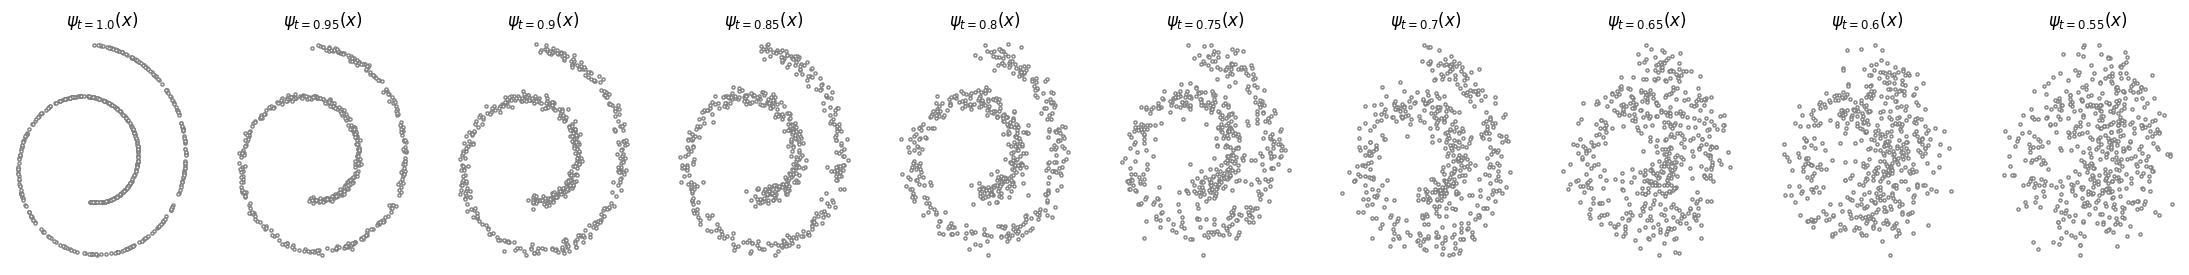

In [14]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i, t in enumerate(np.arange(1, 0.5, -0.05)):
    x_t = fm.conditional_psi_sample(target_ds[:num_vis_particles].to(device), (torch.ones(num_vis_particles) * t).to(device))
    x_t = x_t.cpu()
    axs[i].scatter(x_t[:,0], x_t[:,1], color='white',edgecolor='gray', s=5)
    axs[i].set_axis_off()
    axs[i].set_title('$\psi_{t='+str(t.round(2))+'}(x)$')

## Training of Flow Model

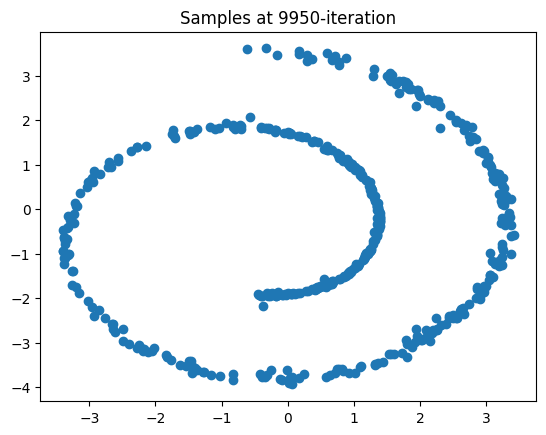

loss: 2.4977: 100%|██████████| 10000/10000 [01:44<00:00, 95.75it/s]


interactive(children=(IntSlider(value=1, description='index', max=50), Output()), _dom_classes=('widget-intera…

Output()

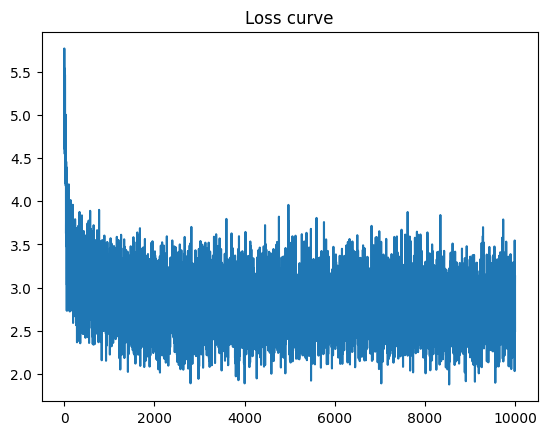

In [15]:
def figure2image(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

# for reproducibility (Oct 14th)
seed_everything(SEED)

# Initialize the model.
fm = build_fm(config)

pbar = tqdm(range(config["num_train_iters"]))
optimizer = torch.optim.Adam(fm.parameters(), lr=config["lr"])
train_dl = torch.utils.data.DataLoader(target_ds, batch_size=config["batch_size"])
train_iter = get_data_iterator(train_dl)

losses = []
images = []
try:
    for step in pbar:
        optimizer.zero_grad()

        batch_x = next(train_iter)
        batch_x = batch_x.to(device)
        loss = fm.compute_loss(batch_x)

        loss.backward()
        optimizer.step()
        pbar.set_description(f"loss: {loss.item():.4f}")

        losses.append(loss.item())

        if step % 199 == 0:
            with torch.no_grad():
                x0 = fm.sample(shape=(num_vis_particles, 2)).cpu()

                fig, ax = plt.subplots(1,1)
                ax.scatter(x0[:,0], x0[:,1])
                ax.set_title(f"Samples at {step}-iteration")
                clear_output(wait=True)
                plt.show()
                img = figure2image(fig)
                images.append(img)

except KeyboardInterrupt:
    pass
finally:
    if len(images) > 0:
        slider = IntSlider(min=0, max=len(images)-1, step=1, value=1)
        output = Output()
        def display_image(index):
            with output:
                output.clear_output(wait=True)
                display(images[index])
        interact(display_image, index=slider)
        display(output)
        plt.plot(losses)
        plt.title("Loss curve")

## Evaluation of Flow Model

Flow Matching Chamfer Distance: 24.1629


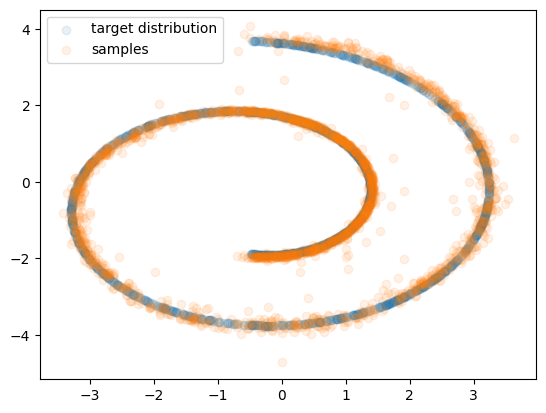

In [16]:
# for reproducibility (Oct 14th)
seed_everything(SEED)

num_eval_particles = 2048
pc_ref = target_ds[:num_eval_particles]
pc_gen = fm.sample(shape=(num_eval_particles, 2), num_inference_timesteps=50)

pc_gen = pc_gen.reshape(num_eval_particles, 2).cpu().numpy()
pc_ref = pc_ref.reshape(num_eval_particles, 2).cpu().numpy()
with torch.no_grad():
    cd = chamfer_distance(
        pc_gen,
        pc_ref,
    )
    print(f"Flow Matching Chamfer Distance: {cd.item():.4f}")

# Visualize samples with the target distribution.
fig, ax = plt.subplots(1,1)
ax.scatter(pc_ref[:,0], pc_ref[:,1], alpha=0.1, label="target distribution")
ax.scatter(pc_gen[:,0], pc_gen[:,1], alpha=0.1, label="samples")
ax.legend()
plt.show()

## Rectified Flow for Accelerated Sampling

Although our flow model effectively approximates the target distribution, it still requires multiple sampling steps to produce high-quality samples. Consequently, reducing the number of required steps has emerged as a critical challenge, one that has been the focus of extensive research.

As a motivating example, we generate 2D points using our previously trained model while restricting sampling timesteps to 10. As shown, the higher CD values indicate that sample quality degrades substantially under the reduced budget, even though the model was adequately trained.

Flow Matching Chamfer Distance: 42.8452


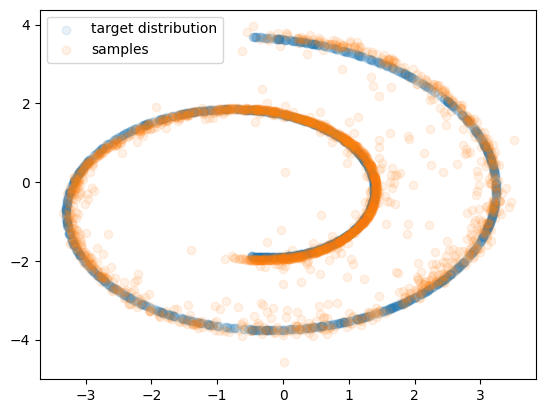

In [17]:
# for reproducibility (Oct 14th)
seed_everything(SEED)

num_eval_particles = 2048
pc_ref = target_ds[:num_eval_particles]
pc_gen = fm.sample(shape=(num_eval_particles, 2), num_inference_timesteps=10)

pc_gen = pc_gen.reshape(num_eval_particles, 2).cpu().numpy()
pc_ref = pc_ref.reshape(num_eval_particles, 2).cpu().numpy()
with torch.no_grad():
    cd = chamfer_distance(
        pc_gen,
        pc_ref,
    )
    print(f"Flow Matching Chamfer Distance: {cd.item():.4f}")

# Visualize samples with the target distribution.
fig, ax = plt.subplots(1,1)
ax.scatter(pc_ref[:,0], pc_ref[:,1], alpha=0.1, label="target distribution")
ax.scatter(pc_gen[:,0], pc_gen[:,1], alpha=0.1, label="samples")
ax.legend()
plt.show()

## Rectified Flow: Making Paths as Straight as Possible

One interesting solution to the problem above starts from the inspection of the sampling trajectories: the paths connecting samples from the prior and target distributions.

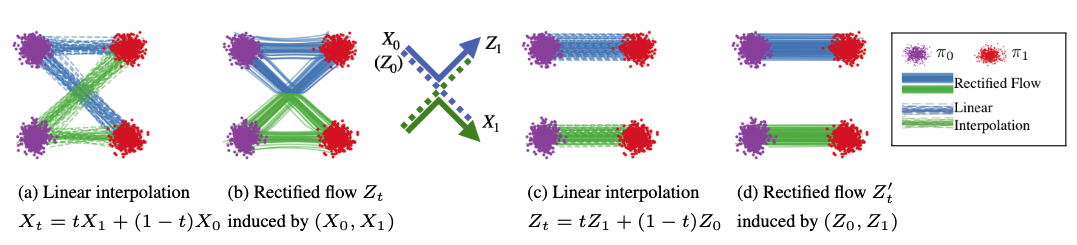

As illustrated in the image above, following a non-straight path (left) requires many steps, since the vector field changes direction along the way. In contrast, if the vector field is nearly straight (right), far fewer steps are needed because its direction remains almost constant over time. In the most extreme case—the ideally straight path—we can estimate the vector field just once and integrate a single step to reach the target distribution.

The remaining question, then, is how to *flatten* the paths learned by our flow models. Surprisingly, this can be achieved quite easily: **generate pairs of noisy and clean data samples using the previously trained flow model, and then train a new flow model on these pairs following exactly the same flow matching procedure**. This technique is called *rectification*, and is implemented as the following steps:
1. Generate pairs ($x_0$, $x_1$) by sampling $x_0$ from $p_{\text{prior}}$ and solving an ODE with the learned flow model $v_t(\cdot; \theta)$ that produces $x_1 \sim p_1$.
2. Compute $x_t = (1-t) x_0 + t x_1$, as well as $v_t = x_1 - (1 - \sigma_{\text{min}}) x_0$, and update parameters $\Phi$ of the new (rectified) flow model by optimizing $L_{\text{CFM}} (\Phi)$.

We will implement and test rectification in the following blocks.

## Generating Data Pairs

- Complete the methods `__init__` and `__getitem__` in the following block.
- Initialize an instance of `RectFlowDataset` with the samples generated using our flow model.

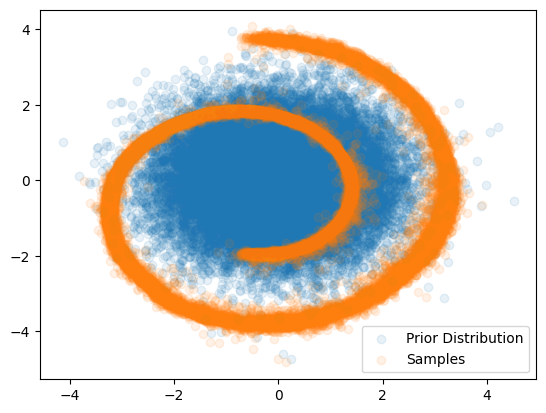

In [18]:
from re import X
class RectFlowDataset(Dataset):
    def __init__(
        self,
        X0: torch.Tensor,
        X1: torch.Tensor,
        batch_size: int,
        dimension=2,
      ):
        ######## TODO ########
        # Complete the constructor
        self.X0=X0
        self.X1= X1
        self.batch_size=batch_size
        self.dimension=dimension
        ######################

    def __len__(self):
        return self.X0.shape[0]

    def __getitem__(self, idx):
        ######## TODO ########
        # Complete the method for data retrieval
        ## return the (x1, x0) pair at a given index
        return self.X1[idx], self.X0[idx]
        ######################

    def get_dataloader(self, shuffle=True):
        return DataLoader(
            self,
            batch_size=self.batch_size,
            shuffle=shuffle,
            pin_memory=True,
        )

# for reproducibility (Oct 14th)
seed_everything(SEED)

# Generate dataset by sampling the pre-trained flow model.
n_example = 32768
traj = fm.sample(
  shape=(n_example, 2),
  return_traj=True,
  num_inference_timesteps=100,
)
######## TODO ########
# Initialize dataset object
pc_0= traj[0].detach() # the noise
pc_1= traj[-1].detach() # the generated data
rect_ds=RectFlowDataset(X0=pc_0, X1=pc_1, batch_size=config['batch_size'])
######################

# Visualize samples with the target distribution.
fig, ax = plt.subplots(1,1)
ax.scatter(pc_0[:,0].cpu().numpy(), pc_0[:,1].cpu().numpy(), alpha=0.1, label="Prior Distribution")
ax.scatter(pc_1[:,0].cpu().numpy(), pc_1[:,1].cpu().numpy(), alpha=0.1, label="Samples")
ax.legend()
plt.show()

## Training of Rectified Flow

- Compute the code block for parsing the loaded training data and computing the loss.

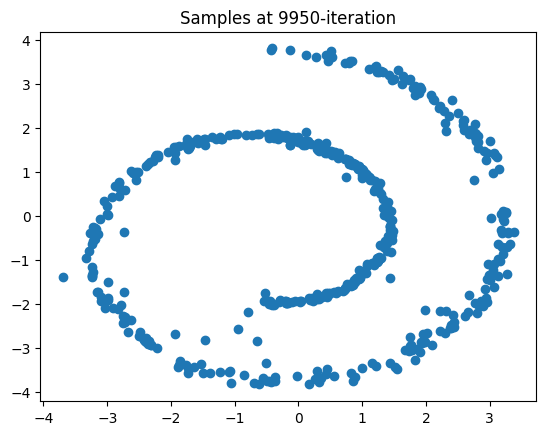

loss: 0.0015: 100%|██████████| 10000/10000 [01:44<00:00, 95.28it/s]


interactive(children=(IntSlider(value=1, description='index', max=50), Output()), _dom_classes=('widget-intera…

Output()

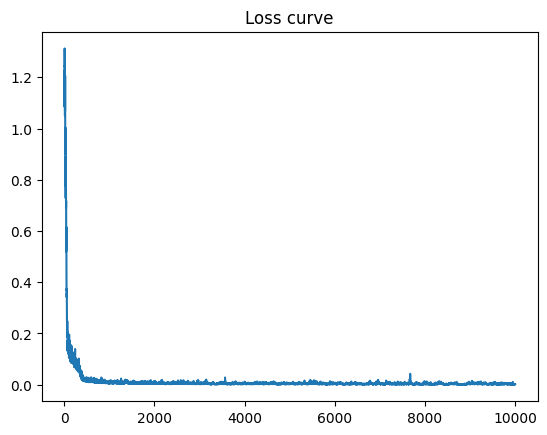

In [22]:
# for reproducibility (Oct 14th)
seed_everything(SEED)

# Build the model. We keep the same architecture here.
rect_fm = build_fm(config)

pbar = tqdm(range(config["num_train_iters"]))
optimizer = torch.optim.Adam(rect_fm.parameters(), lr=config["lr"])
train_dl = torch.utils.data.DataLoader(rect_ds, batch_size=config["batch_size"])
train_iter = get_data_iterator(train_dl)

# Run training
losses = []
images = []
try:
    for step in pbar:
        optimizer.zero_grad()

        ######## TODO ########
        # Parse the loaded data and compute flow matching loss
        #1. unpack the coupled datasets
        batch=next(train_iter)
        x1,x0=batch
        x1 = x1.to(config["device"])
        x0 = x0.to(config["device"])
        #2. loss
        loss = rect_fm.compute_loss(x1, x0=x0)
        ######################

        loss.backward()
        optimizer.step()
        pbar.set_description(f"loss: {loss.item():.4f}")

        losses.append(loss.item())

        if step % 199 == 0:
            with torch.no_grad():
                x0 = rect_fm.sample(
                    shape=(num_vis_particles, 2),
                    num_inference_timesteps=10,
                  ).cpu()

                fig, ax = plt.subplots(1,1)
                ax.scatter(x0[:,0], x0[:,1])
                ax.set_title(f"Samples at {step}-iteration")
                clear_output(wait=True)
                plt.show()
                img = figure2image(fig)
                images.append(img)

except KeyboardInterrupt:
    pass
finally:
    if len(images) > 0:
        slider = IntSlider(min=0, max=len(images)-1, step=1, value=1)
        output = Output()
        def display_image(index):
            with output:
                output.clear_output(wait=True)
                display(images[index])
        interact(display_image, index=slider)
        display(output)
        plt.plot(losses)
        plt.title("Loss curve")

## Evaluation of Rectified Flow Model

Rectified Flow Matching Chamfer Distance: 29.1422


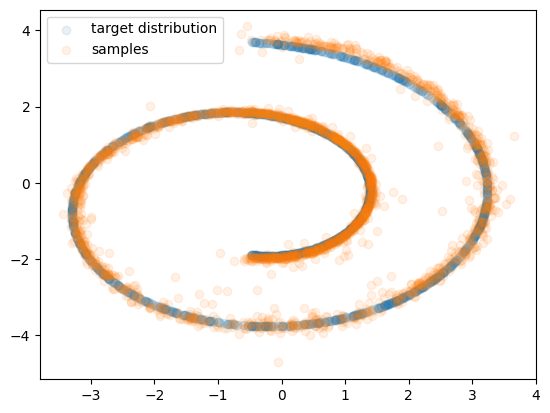

In [23]:
# for reproducibility (Oct 14th)
seed_everything(SEED)

num_eval_particles = 2048
pc_ref = target_ds[:num_eval_particles]
pc_gen = rect_fm.sample(shape=(num_eval_particles, 2), num_inference_timesteps=10)

pc_gen = pc_gen.reshape(num_eval_particles, 2).cpu().numpy()
pc_ref = pc_ref.reshape(num_eval_particles, 2).cpu().numpy()
with torch.no_grad():
    cd = chamfer_distance(
        pc_gen,
        pc_ref,
    )
    print(f"Rectified Flow Matching Chamfer Distance: {cd.item():.4f}")

# Visualize samples with the target distribution.
fig, ax = plt.subplots(1,1)
ax.scatter(pc_ref[:,0], pc_ref[:,1], alpha=0.1, label="target distribution")
ax.scatter(pc_gen[:,0], pc_gen[:,1], alpha=0.1, label="samples")
ax.legend()
plt.show()

## What to Submit

<details>
<summary><b>Submission Item List (Click to Expand)</b></summary>
</br>

- [ ] This notebook file

- [ ] A screenshot of loss curve (Section `Training of Flow Model`)
- [ ] A screenshot of Chamfer distance (Section `Evaluation of Flow Model`)
- [ ] Visualization of generated samples (Section `Evaluation of Flow Model`)
- [ ] A screenshot of loss curve (Section `Training of Rectified Flow Model`)
- [ ] A screenshot of Chamfer distance (Section `Evaluation of Rectified Flow Model`)
- [ ] Visualization of generated samples (Section `Evaluation of Rectified Flow Model`)


</details>


Submit a single ZIP file named `{NAME}_{STUDENT_ID}.zip` containing the following items:

1. Jupyter notebook file containing your code implementation.
2. A single PDF document named `{NAME}_{STUDENT_ID}.pdf` that includes:
    - Your name and student ID
    - All results listed in the submission item list above (screenshots, metrics, visualizations, etc.)


## Grading

**You will receive a zero score if:**
- **you do not submit,**
- **your code is not reproducible, or**
- **you modify any code outside of the section enclosed with `TODO` or use different hyperparameters that are supposed to be fixed as given.**

**Plagiarism in any form will also result in a zero score and will be reported to the university.**

**Your score will incur a 10% deduction for each missing item.**

Otherwise, you will receive up to 20 points from this assignment that count toward your final grade.

- Flow Matching
  - 10 points: Achieve CD lower than **40**.
  - 5 points: Achieve CD between **40** and **80**.
  - 0 point: otherwise.
- Rectified Flow
  - 10 points: Achieve CD lower than **70**.
  - 5 points: Achieve CD between **70** and **110**.
  - 0 point: otherwise.

## Further Readings

If you are interested in this topic, we encourage you to check out the further materials below.

- [Flow Matching for Generative Modeling](https://arxiv.org/abs/2210.02747)
- [Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow](https://arxiv.org/abs/2209.03003)
- [An Introduction to Flow Matching](https://mlg.eng.cam.ac.uk/blog/2024/01/20/flow-matching.html)
- [Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366)